In [1]:
!pip install numpy matplotlib torch torchvision torchaudio
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 12.7 MB/s eta 0:00:00


In [3]:
# TORCH IMPORTS
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn


from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from torchmetrics import Accuracy, ConfusionMatrix, Precision, Recall, F1Score
# MACHINE LEARNING IMPORTS 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
# PYTHON IMPORTS 
import os 
import tarfile
from tqdm import tqdm
from statistics import mean 

In [96]:
def load_data(path):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
        ]
    )

    return datasets.ImageFolder(root=path, transform=transform) # setting to tensor
dataset = load_data('dataset')

In [92]:

project_name="Eye_Disease_Classification-Iteration-1"

# NUMBER OF CLASSES 
num_classes = len(set(dataset.targets))
classes = dataset.classes
classes, num_classes

(['notebook_files'], 1)

Label:  notebook_files


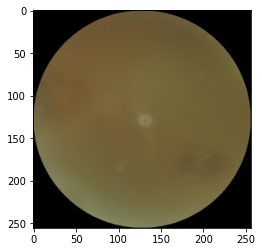

In [84]:
# VISUALIZING IMAGES 
def display_image(image, label):
    print("Label: ", dataset.classes[label])
    # reverses the order of the dimension by indexes specified - 3x32x32 -> 32, 32, 3
    plt.imshow(image.permute(1, 2, 0)) 

# display the first image (and any) with *operant 
display_image(*dataset[0])

In [85]:

def train_test_split(dataset, train_size, random_state=42):
    train_size = int(train_size * len(dataset)) 
    test_size = len(dataset) - train_size
    seed = torch.Generator().manual_seed(random_state) # setting random generator
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=seed)
    
    print("Training dataset", train_dataset)
    print("Testing dataset", test_dataset)
    
    return train_dataset, test_dataset

train_dataset, test_dataset = train_test_split(dataset, 0.8) # splitting 80/20
    
# DATALOADER 
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# num_workers increases processing speed 

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# VISUALIZING THE BATCH SIZES

Training dataset <torch.utils.data.dataset.Subset object at 0x7faee1a75820>
Testing dataset <torch.utils.data.dataset.Subset object at 0x7faf56c94580>


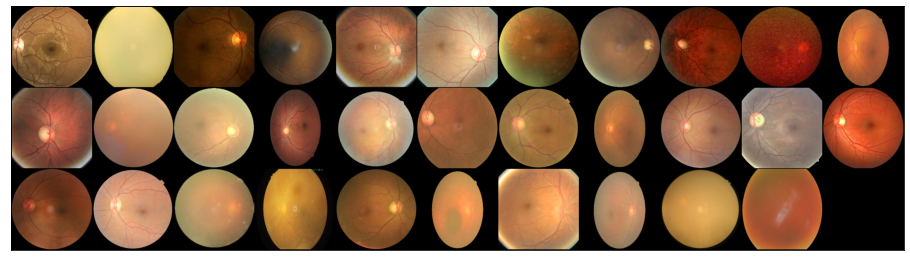

In [86]:
def show_batch(type_data_loader):
    for images, labels in type_data_loader:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([]); ax.set_yticks([]) # remove all ticks on x, y axis
        ax.imshow(make_grid(images, nrow=11).permute(1, 2, 0)) # change input by index 
        break # break after first image input
        

show_batch(train_dataloader)

In [87]:
class CNN(nn.Module):
    def __init__(self, number_of_classes):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),# batch norm on input channels
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=2), # 32 after maxpooling
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # RUNNING DENSE LAYERS ON THE NETWORK - 
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.2), # randomly dropping 20% neurons
            nn.Linear(128, number_of_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dense_layers(x)
        
        return x # x is the final tensor from all the convolutions

In [88]:
model = CNN(num_classes) # initializing the model
if torch.cuda.is_available():
    device = "gpu" # if you have a gpu, use it
else:
    device = "cpu"
    
criterion = nn.CrossEntropyLoss() # using crossentropy loss for the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # using Adam optimizer on the weights + biases of the model

In [89]:
# TRAINING THE NETWORK
def batch_train(model, criterion, optimizer, train_loader, test_loader, epochs):
    model.to(device)
    
    for epoch in range(epochs):
        train_loss = []
        accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        for inputs, targets in train_loader:
            # move data to GPU or CPU
            inputs, targets = inputs.to(device), targets.to(device)
            
            # set previous gradients to zero to prevent gradient build up
            optimizer.zero_grad()
            
            # forward pass 
            outputs = model(inputs)
            loss = criterion(outputs, targets) # computing the losses of the prediction tensors with the labeled ones
            
            # backpropagate 
            loss.backward() # updates the gradients of the model
            optimizer.step() # updates the hyperparameters of the model
            
            train_loss.append(loss.item()) # appending the numeric value of the loss for that input 
            
        # training loss 
        train_loss_mean = np.mean(train_loss) # training loss of the model 

        # training accuracy 
        train_acc = accuracy(outputs, targets)
        
        
        # EVALUATING THE TESTING DATASET 
        
        test_loss = []
        for inputs, targets in test_loader:
            # move data to GPU or CPU
            inputs, targets = inputs.to(device), targets.to(device)
            
            # forward pass 
            outputs = model(inputs)
            loss = criterion(outputs, targets) # computing the losses of the prediction tensors with the labeled ones
            
            test_loss.append(loss.item()) # appending the numeric value of the loss for that input 
            
        # training loss 
        test_loss_mean = np.mean(train_loss) # training loss of the model 

        # training accuracy 
        test_acc = accuracy(outputs, targets)
        
        # SAVING EACH ITERATION'S LOSS + ACCURACY TO THEIR RESPECTIVE LISTS
        train_loss[epoch] = train_loss_mean
        test_loss[epoch] = test_loss_mean

        print(f"Epoch {epoch+1}/{epochs}:")
        print(
            f"Train Loss: {train_loss_mean:.2f}, Train Accuracy: {train_acc:.2f}")
        print(
            f"Test Loss: {test_loss_mean:.2f}, Test Accuracy: {test_acc:.2f}")
        print('-'*30)

    return train_loss, test_loss # return the accuracies of each model 

# evaluating the performance of the model on real data


        
    

In [90]:
train_losses, test_losses = batch_train(model=model, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader, test_loader=test_dataloader, epochs=10)

ValueError: ValueError: Expected argument `num_classes` to be an integer larger than 1, but got 1

In [66]:

# VISUALIZING IMAGES 
def display_image(image, label):
    print("Label: ", dataset.classes[label])
    # reverses the order of the dimension by indexes specified - 3x32x32 -> 32, 32, 3
    plt.imshow(image.permute(1, 2, 0)) 

In [74]:
y_prediction = []
y_actual = []

def predict_model(data):
    with torch.no_grad():
        for inputs, targets in data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs) # output of the model 
            _, predictions = torch.max(outputs, 1) # 

            print("predictions", predictions)

            y_prediction.append(targets.cpu().numpy())
            y_actual.append(predictions.cpu().numpy())
            
            # will collapse the 2nd dimensions, resulting in predicted tensors and their respective inde
            # max of the indexes are the correct index classification
            # each layer will 
            # ()

    return y_prediction, y_actual, outputs, predictions
        
predict_model(test_dataloader)

predictions tensor([3, 2, 3, 3, 0, 2, 3, 2, 0, 0, 1, 3, 1, 1, 3, 3, 2, 2, 3, 1, 1, 0, 3, 2,
        3, 2, 0, 2, 1, 3, 0, 1])
predictions tensor([3, 2, 3, 3, 3, 3, 1, 1, 2, 2, 3, 3, 0, 1, 3, 1, 3, 0, 1, 1, 2, 3, 3, 0,
        0, 1, 3, 1, 1, 0, 3, 3])
predictions tensor([1, 0, 1, 3, 0, 2, 2, 3, 3, 3, 3, 1, 1, 1, 3, 2, 2, 0, 2, 0, 3, 3, 1, 2,
        1, 1, 2, 0, 3, 0, 3, 1])
predictions tensor([1, 0, 2, 3, 0, 2, 0, 3, 3, 3, 3, 3, 1, 2, 0, 0, 3, 3, 3, 1, 2, 2, 0, 2,
        3, 2, 3, 0, 2, 1, 0, 1])
predictions tensor([3, 2, 3, 1, 0, 3, 3, 3, 1, 1, 1, 2, 0, 0, 0, 1, 3, 1, 3, 3, 1, 2, 0, 0,
        3, 3, 3, 3, 1, 0, 3, 2])
predictions tensor([1, 3, 2, 0, 3, 2, 0, 3, 3, 2, 0, 1, 3, 0, 0, 3, 1, 1, 1, 3, 2, 1, 2, 3,
        3, 3, 0, 1, 2, 1, 2, 0])
predictions tensor([3, 3, 3, 0, 3, 3, 3, 2, 1, 0, 1, 1, 1, 1, 3, 3, 0, 0, 3, 0, 0, 1, 0, 2,
        0, 2, 1, 1, 3, 2, 0, 0])
predictions tensor([3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 0, 1, 2, 0, 3, 3, 1, 2, 2, 1, 3, 3, 0, 3,
        0, 0, 1, 3, 2, 1, 3, 0])


([array([3, 1, 0, 0, 3, 2, 3, 3, 0, 0, 2, 0, 1, 3, 3, 3, 1, 1, 0, 2, 1, 0,
         3, 2, 0, 0, 2, 2, 0, 3, 0, 1]),
  array([3, 1, 2, 0, 2, 2, 1, 1, 1, 2, 0, 1, 2, 1, 3, 1, 2, 3, 2, 1, 0, 1,
         3, 0, 0, 1, 2, 1, 1, 3, 0, 3]),
  array([1, 0, 1, 3, 0, 2, 3, 3, 0, 3, 2, 1, 1, 1, 2, 2, 1, 0, 3, 0, 0, 2,
         1, 0, 1, 3, 2, 0, 3, 0, 3, 1]),
  array([1, 0, 2, 3, 2, 1, 3, 2, 0, 0, 2, 3, 0, 2, 0, 3, 1, 0, 3, 2, 2, 0,
         0, 0, 3, 3, 2, 0, 2, 0, 0, 1]),
  array([3, 3, 2, 2, 0, 1, 3, 2, 1, 1, 1, 2, 3, 0, 0, 1, 0, 1, 2, 0, 1, 2,
         3, 0, 2, 2, 3, 3, 1, 3, 3, 2]),
  array([3, 0, 3, 2, 3, 2, 2, 3, 3, 2, 0, 1, 3, 2, 0, 2, 1, 1, 1, 0, 1, 1,
         2, 0, 3, 0, 0, 1, 3, 1, 2, 0]),
  array([3, 3, 3, 3, 3, 2, 3, 0, 1, 2, 1, 1, 1, 1, 0, 3, 1, 3, 3, 0, 0, 1,
         0, 2, 3, 0, 1, 1, 2, 2, 3, 2]),
  array([2, 3, 0, 2, 3, 0, 2, 2, 1, 3, 0, 1, 2, 3, 1, 2, 1, 0, 3, 1, 3, 2,
         3, 2, 0, 0, 1, 3, 0, 1, 3, 0]),
  array([3, 2, 1, 2, 1, 0, 1, 2, 2, 0, 3, 3, 3, 1, 1, 2, 1, 2, 0, 2, 3, 

In [76]:

targets = torch.tensor(np.concatenate(y_prediction))
preds = torch.tensor(np.concatenate(y_actual))

targets, preds

(tensor([3, 1, 0, 0, 3, 2, 3, 3, 0, 0, 2, 0, 1, 3, 3, 3, 1, 1, 0, 2, 1, 0, 3, 2,
         0, 0, 2, 2, 0, 3, 0, 1, 3, 1, 2, 0, 2, 2, 1, 1, 1, 2, 0, 1, 2, 1, 3, 1,
         2, 3, 2, 1, 0, 1, 3, 0, 0, 1, 2, 1, 1, 3, 0, 3, 1, 0, 1, 3, 0, 2, 3, 3,
         0, 3, 2, 1, 1, 1, 2, 2, 1, 0, 3, 0, 0, 2, 1, 0, 1, 3, 2, 0, 3, 0, 3, 1,
         1, 0, 2, 3, 2, 1, 3, 2, 0, 0, 2, 3, 0, 2, 0, 3, 1, 0, 3, 2, 2, 0, 0, 0,
         3, 3, 2, 0, 2, 0, 0, 1, 3, 3, 2, 2, 0, 1, 3, 2, 1, 1, 1, 2, 3, 0, 0, 1,
         0, 1, 2, 0, 1, 2, 3, 0, 2, 2, 3, 3, 1, 3, 3, 2, 3, 0, 3, 2, 3, 2, 2, 3,
         3, 2, 0, 1, 3, 2, 0, 2, 1, 1, 1, 0, 1, 1, 2, 0, 3, 0, 0, 1, 3, 1, 2, 0,
         3, 3, 3, 3, 3, 2, 3, 0, 1, 2, 1, 1, 1, 1, 0, 3, 1, 3, 3, 0, 0, 1, 0, 2,
         3, 0, 1, 1, 2, 2, 3, 2, 2, 3, 0, 2, 3, 0, 2, 2, 1, 3, 0, 1, 2, 3, 1, 2,
         1, 0, 3, 1, 3, 2, 3, 2, 0, 0, 1, 3, 0, 1, 3, 0, 3, 2, 1, 2, 1, 0, 1, 2,
         2, 0, 3, 3, 3, 1, 1, 2, 1, 2, 0, 2, 3, 1, 0, 1, 2, 0, 2, 3, 3, 1, 3, 2,
         0, 0, 0, 2, 1, 2, 2

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [19]:
accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)
accuracy = accuracy(preds, targets)
print(f"Accuracy: {100 * accuracy:.2f}%")

Accuracy: 55.92%


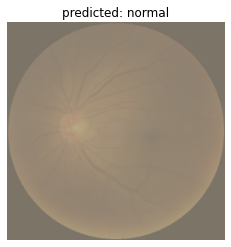

In [69]:
def visualize():
    fig = plt.figure()
    images=1
    images_so_far = 0
    model.eval()
    with torch.no_grad():

        for inputs, targets in test_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far+=1
                ax = plt.subplot()
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}')
                imshow(inputs.cpu().data[j])
                if images_so_far == images:
                    model.train(mode=model.training)
                    return
            model.train(mode=model.training)
           
visualize()

In [71]:
torch.save(model.state_dict(), "model.pth")

Dataset ImageFolder
    Number of datapoints: 4217
    Root location: /data/
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
           )